# 連続測定デモ

## 既知の問題

- <s>毎回のジョブ投入時に分類器のキャリブレーション (30秒程度)を実施しているので、測定時間がそれと同程度に短いと、duty比が落ちる</s>
    - 対応済み。オプションの使用である程度改善するが、結局ジョブ投入のオーバーヘッドが残る。

In [1]:
PROGRAM_NAME = "07_repeat_single_shot_v3"

In [2]:
from quri_parts_oqtopus.backend import OqtopusSseBackend
from oqtopus_sse_pulse.adapter import QuriAdapter, collect_payloads_from_job, collect_session_from_job
from oqtopus_sse_pulse.plotters import plot_payload

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DEVICE = "anemone" # デバイス名 (勉強会ではanemoneに固定)
backend = OqtopusSseBackend() # OqtopusSseBackendのインスタンスを作成

def experiment(program: str) -> list:
    """
    指定した実験プログラムを実行し, 測定結果のペイロードを返す関数.
    """

    # ジョブの実行
    job = backend.run_sse(
        file_path=f"program/{program}.py",
        device_id=f"{DEVICE}-pulse",
        name=program,
    )
    print(f"job_id = {job.job_id}")

    # ジョブの完了待ち
    job.wait_for_completion()
    print(f"job_status = {job.status}  elapsed={job.execution_time}")

    # QuriAdapterの作成
    adapter = QuriAdapter(backend)

    # 測定結果の取得
    payloads = collect_payloads_from_job(
        backend=adapter,
        job_id=job.job_id,
    )
    
    return payloads

In [ ]:
timeout = 1 * 60    # タイムアウト時間 (秒)
elapsed_time = 0.0
payloads_calib = []
payloads_res = []

import time

count = 0

while True:
    print(f"=== iteration: {count} ===")

    start_time = time.time()

    payloads = experiment(PROGRAM_NAME)

    end_time = time.time()
    elapsed = end_time - start_time
    elapsed_time += elapsed
    print(f"elapsed_time = {elapsed_time} seconds")

    print(f"len(payloads) = {len(payloads)}")
    print(payloads[0])

    payloads_calib.append(payloads[0])
    payloads_res.extend(payloads[1:])

    if elapsed_time > timeout:
        print("Timeout reached. Stopping the loop.")
        break

    count += 1

=== iteration: 0 ===
job_id = 0695e5f8-1712-7ecc-8000-0101848bd117
job_status = succeeded  elapsed=68.199
elapsed_time = 83.39135122299194 seconds
len(payloads) = 5
{'props': {'readout_fidelities': {'Q36': [0.9895, 0.3933], 'Q38': [0.9725, 0.8758], 'Q40': [0.9087, 0.8222]}, 'average_readout_fidelity': {'Q36': 0.6914, 'Q38': 0.92415, 'Q40': 0.86545}}}
=== iteration: 1 ===
job_id = 0695e5fd-4af8-7e1f-8000-81360a016bec
job_status = succeeded  elapsed=68.622
elapsed_time = 165.7153091430664 seconds
len(payloads) = 5
{'props': {'readout_fidelities': {'Q36': [0.9859, 0.4282], 'Q38': [0.9693, 0.8714], 'Q40': [0.9043, 0.8204]}, 'average_readout_fidelity': {'Q36': 0.70705, 'Q38': 0.92035, 'Q40': 0.86235}}}
Timeout reached. Stopping the loop.


In [11]:
import pickle

with open("data/payloads_res.pkl", "wb") as f:
    pickle.dump(payloads_res, f)
with open("data/payloads_calib.pkl", "wb") as f:
    pickle.dump(payloads_calib, f)

In [12]:
# デコード

import numpy as np
import base64

# base64文字列を読み込む
p = payloads_res[0]

def decode_states(states: str, num_shots: int) -> np.ndarray:
    packed_b64 = states

    # base64デコードしてバイト列に戻す
    packed_bytes = base64.b64decode(packed_b64)

    # numpy配列に変換
    packed = np.frombuffer(packed_bytes, dtype=np.uint8)

    # 元の長さを知っていれば（例: 5）、unpackbitsで復元
    arr_restored = np.unpackbits(packed)[:num_shots]

    return arr_restored

In [13]:
import datetime
import numpy as np

averaging = True

unix_times = np.array([])
num_errors = np.array([])

for i, q in enumerate(payloads_res):
    start_time = q.get("start_time")
    unix_time = start_time
    if i == 0:
        time_origin = unix_time
    unix_time -= time_origin
    dt = q.get("dt")

    states = q.get("states")
    qubits = list(states.keys())
    # if "Q39" in qubits:
    #     qubits.remove("Q39")  # Q39は終わっているので除外
    num_qubits = len(qubits)
    for j, qubit in enumerate(qubits):
        if j == 0:
            num_normal_qubits = decode_states(states[qubit], q.get("num_shots"))
            # num_normal_qubits = np.array(states[qubit])
        else:
            num_normal_qubits += decode_states(states[qubit], q.get("num_shots"))
            # num_normal_qubits += np.array(states[qubit])
    num_measurements = num_normal_qubits.shape[0]
    times = (np.arange(num_measurements) * dt + unix_time) / 1e9  # 秒単位に変換

    if averaging:
        window_size = 10
        num_windows = num_measurements // window_size
        num_normal_qubits = num_normal_qubits[:num_windows * window_size].reshape(-1, window_size).mean(axis=1)
        times = times[:num_windows * window_size].reshape(-1, window_size).mean(axis=1)

    num_errors = np.append(num_errors, 1 - num_normal_qubits / num_qubits)
    unix_times = np.append(unix_times, times)

print(unix_times)
print(num_errors)
        

[4.57236000e-04 1.47331600e-03 2.48939600e-03 ... 1.23944044e+02
 1.23945060e+02 1.23946076e+02]
[0.63333333 0.5        0.53333333 ... 0.5        0.4        0.8       ]


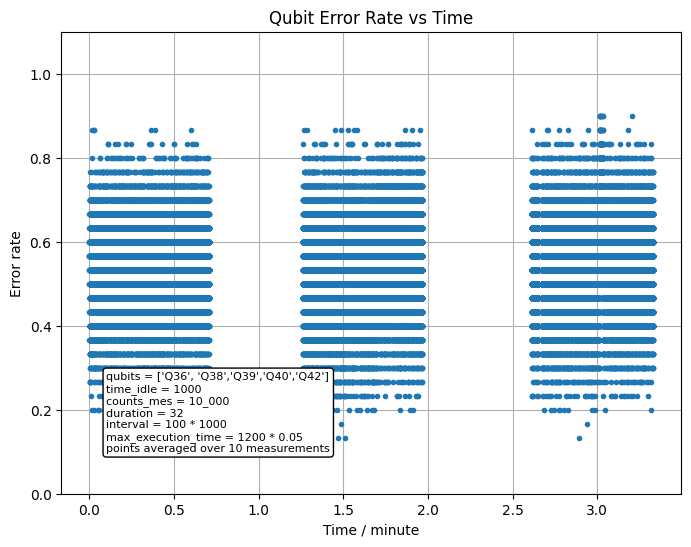

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 6))
text = f"""qubits = ['Q36', 'Q38', 'Q40']
time_idle = 1000
counts_mes = 100_000
duration = 32
interval = 100 * 1000
max_execution_time = 1200 * 0.05
points averaged over {window_size} measurements"""
boxdic = {
    "facecolor" : "white",
    "edgecolor" : "black",
    "boxstyle" : "Round",
    "linewidth" : 1
}
ax.text(0.1, 0.1, text, bbox=boxdic, fontsize=8)
plt.plot(unix_times / 60, num_errors, ".")
plt.xlabel("Time / minute")
plt.ylabel("Error rate")
plt.ylim(0, 1.1)
plt.title("Qubit Error Rate vs Time")
plt.grid()
plt.show()